## Day 22 Lecture 2 Assignment

In this assignment, we will do apply the feature engineering techniques we have learned to create new features from existing ones. We will be using both the FIFA ratings dataset and the Chicago traffic crash dataset.

In [81]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [82]:
df2 = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/traffic_crashes_chicago.csv')
df = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/fifa_ratings.csv')

In [83]:
df.head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,158023,L. Messi,94,84,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,61,87,94,79,88,68,58,51
4,183277,E. Hazard,91,81,84,61,89,80,95,83,79,83,94,94,88,95,90,94,82,56,83,66,80,54,41,87,89,86,91,34,27,22


We will start with the FIFA soccer ratings dataset. From our EDA in the previous exercise, we saw that most ratings appeared to be somewhat normally distributed, occasionally with long tails. Choose one of the ratings (we will choose Curve) and apply the following transformations:

- Log transformation
- Standardization
- Quantile transformation

Plot the resulting histograms. How do these transformations affect the resulting distributions?

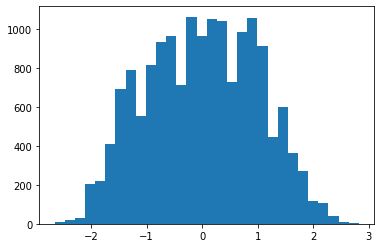

In [84]:
# answer goes here
scaler = StandardScaler()
df['scale_log_curve'] = scaler.fit_transform(df[['Curve']])
plt.hist(df['scale_log_curve'], bins=30)
plt.show()

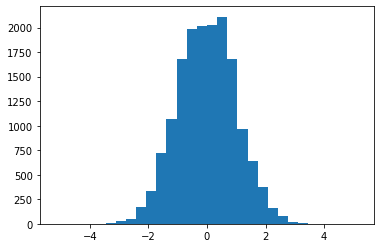

In [85]:
quantile = QuantileTransformer(output_distribution='normal')
df['quant_log_curve'] = quantile.fit_transform(df[['Curve']])
plt.hist(df['quant_log_curve'], bins=30)
plt.show()

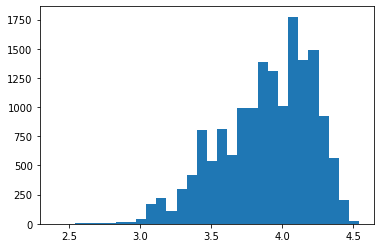

In [86]:
log_curve = df['Curve'].apply(np.log)
plt.hist(log_curve, bins=30)
plt.show()

Next, we will switch our focus to the Chicago traffic crashes dataset. We will create several new features using several common feature engineering techniques.

Start by considering the crash date column. It is usually difficult to directly feed datetimes into machine learning models, but we can extract several features from the datetime that may be more suitable for our use case. 

First, if the CRASH_DATE column is not already a datetime field (it may be read in as a string by default), convert it to a datetime. Then, create three new columns, CRASH_HOUR, CRASH_DAY_OF_WEEK, and CRASH_MONTH, that extract the relevant pieces of information from the crash date field. CRASH_HOUR should be numeric, while CRASH_DAY_OF_WEEK and CRASH_MONTH should be strings (e.g. "Monday" and "December", not 1 and 12).

In [87]:
# answer goes here
df2['CRASH_DATE_TIME'] = pd.to_datetime(df2['CRASH_DATE'])

In [88]:
df2['CRASH_HOUR'] = df2['CRASH_DATE_TIME'].dt.hour
df2['CRASH_DAY_OF_WEEK'] = df2['CRASH_DATE_TIME'].dt.day_name()
df2['CRASH_MONTH'] = df2['CRASH_DATE_TIME'].dt.month_name()

Next, we will work through an example that involves combining two existing features together to make a new one. Convert the DATE_POLICE_NOTIFIED column into a datetime (if it isn't one already), and create a new feature called "REPORTING_DELAY" which corresponds to the number of hours between the crash actually occurring and the police being notified. 

Plot a histogram and a frequency table of the features - are the results reasonable? If there are unusual results, which ones are they and what steps could we consider taking to address them (if such steps are necessary)?

In [89]:
# answer goes here
df2['date_time_police_notified'] = pd.to_datetime(df2['DATE_POLICE_NOTIFIED'])

In [90]:
df2['reporting_delay'] = df2['date_time_police_notified'].dt.hour - df2['CRASH_HOUR']
df2['reporting_delay']

0         1
1         0
2         0
3         0
4         2
         ..
372580    1
372581    0
372582    1
372583    0
372584    0
Name: reporting_delay, Length: 372585, dtype: int64

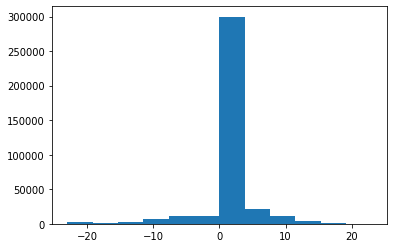

In [91]:
plt.hist(df2['reporting_delay'], bins=12)
plt.show()

Plot a histogram and a frequency table of the features - are the results reasonable? If there are unusual results, which ones are they and what steps could we consider taking to address them (if such steps are necessary)?
**The answers are not reasonable because we recived negative values. However, we think that it could be because hour resets, for instance one accident could have occured at 23:30, and could have been reported at 01:02 the following date. We would have to incorporate the days into the feature**. 

Finally, we will generate a new geographical feature from the BEAT_OF_OCCURRENCE field. This field contains 4-digit identifiers corresponding to areas within Chicago; however, some values may be shorter if the leading digit is 0 (i.e. beat "0114" is represented as "114").

Start by converting the the BEAT_OF_OCCURRENCE field into a string, dropping any unwanted characters that are present (chances are that this field was read in as a number and that "114" is represented as "114.0"; find a way to drop the ".0"), and adding the appropriate number of leading 0s so that every beat is four digits.

In [92]:
# answer goes here
df2['new_beat_of_occurrence'] = df2['BEAT_OF_OCCURRENCE'].apply(str)


In [94]:
df2['new_beat_of_occurrence'] = [sub[ : -2] for sub in df2['new_beat_of_occurrence']] 
df2['new_beat_of_occurrence']

0          114
1          631
2          332
3         1831
4         1921
          ... 
372580     815
372581    1622
372582     512
372583    1733
372584    1011
Name: new_beat_of_occurrence, Length: 372585, dtype: object

In [95]:
df2['new_beat_of_occurrence'] = df2['new_beat_of_occurrence'].apply(lambda x: '0' + str(x) if len(str(x))< 4 else str(x))
df2['new_beat_of_occurrence']

0         0114
1         0631
2         0332
3         1831
4         1921
          ... 
372580    0815
372581    1622
372582    0512
372583    1733
372584    1011
Name: new_beat_of_occurrence, Length: 372585, dtype: object

As it turns out, the first two digits of each beat correspond to a higher-level geographic area. For example, the higher-level beat "24" corresponds to a larger geographic area that is subdivided into beats 2411, 2412, etc. See below for a map illustrating this (in the map, the higher-level codes are three digits, but the first digit is always a zero):

https://news.wttw.com/sites/default/files/Map%20of%20Chicago%20Police%20Districts%20and%20Beats.pdf

Create a new feature called BEAT_TWO_DIGIT that corresponds to the higher-level two-digit geographic area.

As a side note, US zip codes work much the same way:

https://www.unitedstateszipcodes.org/images/zip-codes/zip-codes.png

This is a very common feature engineering technique for US zip codes. Many data sets will contain hundreds or thousands or zip codes, and attempting to feed a categorical variable with a very large number of levels into a model can often lead to problems (imagine trying to one-hot encode this; the number of columns would explode, and most of the columns would be very sparse.) Rolling up zip codes to a higher level loses some detail but greatly mitigates the issue of too many categories while still providing useful geographic insights on many occassions.

In [96]:
# answer goes here

df2['BEAT_TWO_DIGIT'] = [sub[:-2] for sub in df2['new_beat_of_occurrence']] 

df2['BEAT_TWO_DIGIT'] 


0         01
1         06
2         03
3         18
4         19
          ..
372580    08
372581    16
372582    05
372583    17
372584    10
Name: BEAT_TWO_DIGIT, Length: 372585, dtype: object